# <font color=green>Tasselled Cap Wetness Brightness Greenness Epoch Stats Summary Notebook for Kakadu </font>

__Inheritance__ <br>
Based on the raijin-code Dask_Wetness_debug1.py as at 140817. <br>
Add in the explicit epoch chooser


<font color=red>'''
Dask_Wetness_nbarT.py loads surface reflectance data from the data cube, calculates
tasselled cap indices, and outputs a netcdf file. It uses dask to keep memory use low.
--It requires a PBS submission script to provide i, the polygon number to ingest.
Created by Bex Dunn 08/05/2017
Altered to increase the size of the query, to test dask run times, 16/06/17
Altered to use the correct terrain masking nan values 30/06/17
Altered to just use the polygon size again 30/06/17 #FIXME will need to remove the spatial query code (commented out)
Altered to import new ga_pq_fuser function
And to import mask_valid_data as mask_invalid_data as of 010812017
Altered to output clear observation count as well as over threshold count 040817
Altered to check for file existence before running 130817

'''
</font>

-------------------------------------------------------------------- 
The following sensors are available for the following time frames:
* Landsat 5 - 1986 to April 1999  followed by a gap until May 2003 - November 2011 (data from 2009 onwards becomes less reliable in southern Australia)
* Landsat 7 - April 1999 to present, however after May 2003 the scan line corrector (SLC) failed, 
so data are referred to as SLC-off, meaning they've got a venetian blinds appearance with wedges of missing data
  * This data is not well suited for inclusion in composites, but is fine to use in time series analysis
* Landsat 8 - April 2013 onwards
---------------------------------------------------------------------



<div class="alert alert-block alert-info">

__Change log:__
***
-  changed sensors to dictionary 140817
-  changed pq_fuser to ga_pq_fuser and removed alias of pq_fuser to ga_pq_fuser 140817
-  changed from datacube.storage.masking import mask_valid_data as mask_invalid_data to rom datacube.storage.masking    import mask_invalid_data 140817
-  wrote a function to load sensor data irrespective of time period 140817
-  moved terrain filter into the function (check that this works!!!!!!)
-  altered wetness_coefficient dictionary for readability
-  loaded plotting libraries to plot images 150817
-  wrote a function to calculate wetness 230817
***

## Import the python modules we need

In [1]:
#for writing to error files:
from __future__ import print_function
#get some libraries
import datacube
import xarray as xr
from datacube.storage import masking
#from datacube.storage.masking import mask_to_dict #think this is obsolete
import json
import pandas as pd
import shapely
from shapely.geometry import shape
import numpy as np #need this for pq fuser

#libraries for polygon and polygon mask
import fiona
import shapely.geometry
import rasterio.features
import rasterio
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser
from datacube.storage.masking import mask_invalid_data

#for writing to netcdf
from datacube.storage.storage import write_dataset_to_netcdf
#dealing with system commands
import sys
import os.path

#####These not needed for raijin::::
import matplotlib.pyplot as plt

#suppress warnings thrown when using inequalities in numpy (the threshold values!)
import warnings

def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)

## define functions to load nbart, calculate wetness, wetness over threshold, counts, and write datasets to netcdf

In [2]:
def load_nbart(sensor,query,bands_of_interest): 
    '''loads nbart data for a sensor, masks using pq, then filters out terrain -999s
    function written 23-08-2017 based on dc v1.5.1'''  
    dataset = []
    product_name = '{}_{}_albers'.format(sensor, 'nbart')
    print('loading {}'.format(product_name))
    ds = dc.load(product=product_name, measurements=bands_of_interest,
                 group_by='solar_day', **query)
    #grab crs defs from loaded ds if ds exists
    if ds:
        crs = ds.crs
        affine = ds.affine
        print('loaded {}'.format(product_name))
        mask_product = '{}_{}_albers'.format(sensor, 'pq')
        sensor_pq = dc.load(product=mask_product, fuse_func=ga_pq_fuser,
                            group_by='solar_day', **query)
        if sensor_pq:
            print('making mask {}'.format(mask_product))
            cloud_free = masking.make_mask(sensor_pq.pixelquality,
                                           cloud_acca='no_cloud',
                                           cloud_shadow_acca = 'no_cloud_shadow',                           
                                           cloud_shadow_fmask = 'no_cloud_shadow',
                                           cloud_fmask='no_cloud',
                                           blue_saturated = False,
                                           green_saturated = False,
                                           red_saturated = False,
                                           nir_saturated = False,
                                           swir1_saturated = False,
                                           swir2_saturated = False,
                                           contiguous=True)
            ds = ds.where(cloud_free)
            ds.attrs['crs'] = crs
            ds.attrs['affine'] = affine
            print('masked {} with {} and filtered terrain'.format(product_name,mask_product))
            # nbarT is correctly used to correct terrain by replacing -999.0 with nan
            ds=ds.where(ds!=-999.0)
        else: 
            print('did not mask {} with {}'.format(product_name,mask_product))
    else:
        print ('did not load {}'.format(product_name)) 

    if len(ds)>0:
        return ds
    else:
        return None

In [ ]:
def calc_wetness(sensor_data,sensor):
    '''This function multiplies band data by wetness coefficients to produce a "wetness" band.
    sensor_data is surface reflectance data loaded from the datacube
    sensor = 'ls5, 'ls7' or 'ls8'
    Coefficients are from Crist and Cicone 1984 for ls5 and ls7, and from Baig, Zhang, Shuai & Tong for ls8
    function written 23-08-2017 based on dc v1.5.1'''
    
    wetness_coeff ={'ls5':{'blue':0.151, 'green':0.179, 'red':0.330, 'nir':0.341, 'swir1':-0.711, 'swir2':-0.457},
                    'ls7':{'blue':0.151, 'green':0.179, 'red':0.330, 'nir':0.341, 'swir1':-0.711, 'swir2':-0.457},
                    'ls8':{'blue':0.1511,'green':0.1973,'red':0.3283,'nir':0.3407,'swir1':-0.7117,'swir2':-0.4559}}  
    
    #if there is sensor data for the time period
    if sensor_data is not None: 
        #make a deep copy of the sensor data
        wetness = sensor_data.copy(deep=True)
        #iterate over the spectral bands
        for band_name in sensor_data.data_vars:
            #multiply each band by the wetness transform coefficient to get a band-specific wetness value
            wetness_band = sensor_data[band_name]*wetness_coeff[sensor][band_name]
            #update the existing band data with the wetness data
            wetness.update({band_name:(['time','y','x'],wetness_band)})
        #finally, add a wetness data variable to the array that is the sum of the wetness "bands"    
        wetness['wetness']=wetness.blue+wetness.green+wetness.red+wetness.nir+wetness.swir1+wetness.swir2    
        print('calculated wetness for {}'.format(sensor))
        wetness = wetness.drop(('blue','green','red','nir','swir1','swir2'))
        return wetness
    
    else:
        print('did not calculate wetness for {}'.format(sensor))
        return None    

In [ ]:
def calc_tc_wbg(sensor_data,sensor):
    '''This function performs the tasselled cap transformation, multiplying band data by tasselled cap coefficients to 
    produce "wetness, brightness and greenness" "bands".
    sensor_data is surface reflectance data loaded from the datacube
    sensor = 'ls5, 'ls7' or 'ls8'
    Coefficients are from Crist and Cicone 1984 for ls5 and ls7, and from Baig, Zhang, Shuai & Tong for ls8
    function written 23-08-2017 based on dc v1.5.1. amended 12/09/16 to include brightness and greenness'''

    wetness_coeff = {'ls5':{'blue':0.151, 'green':0.179, 'red':0.330, 'nir':0.341, 'swir1':-0.711, 'swir2':-0.457},
                    'ls7':{'blue':0.151, 'green':0.179, 'red':0.330, 'nir':0.341, 'swir1':-0.711, 'swir2':-0.457},
                    'ls8':{'blue':0.1511,'green':0.1973,'red':0.3283,'nir':0.3407,'swir1':-0.7117,'swir2':-0.4559}}
        
    brightness_coeff = {'ls5':{'blue':0.304, 'green':0.279, 'red':0.434, 'nir':0.559, 'swir1':0.508, 'swir2':0.186},
                    'ls7':{'blue':0.304, 'green':0.279, 'red':0.434, 'nir':0.559, 'swir1':0.508, 'swir2':0.1872},
                    'ls8':{'blue':0.3029,'green':0.2786,'red':0.4733,'nir':0.5599,'swir1':0.508,'swir2':0.1872}}  
    
    greenness_coeff = {'ls5':{'blue':-0.285, 'green':-0.244, 'red':-0.544, 'nir':0.724, 'swir1':0.084, 'swir2':-0.180},
                    'ls7':{'blue':-0.285, 'green':-0.244, 'red':-0.544, 'nir':0.724, 'swir1':0.084, 'swir2':-0.180},
                    'ls8':{'blue':-0.2941,'green':-0.243,'red':-0.5424,'nir':0.7276,'swir1':0.0713,'swir2':-0.1608}}
    
############################################################################________________fixing_____####################    
     #if there is sensor data for the time period
    if sensor_data is not None: 
        #make a deep copy of the sensor data
        wbg = sensor_data.copy(deep=True)
        #iterate over the spectral bands
        for band_name in sensor_data.data_vars:
            #multiply each band by the wetness transform coefficient to get a band-specific wetness value
            wetness_band = sensor_data[band_name]*wetness_coeff[sensor][band_name]
            brightness_band = sensor_data[band_name]*brightness_coeff[sensor][band_name]
            greenness_band = sensor_data[band_name]*greenness_coeff[sensor][band_name]
            #update the existing band data with the wetness data
            wbg.update({'wet_'+band_name:(['time','y','x'],wetness_band)})
            wbg.update({'bright_'+band_name:(['time','y','x'],brightness_band)})
            wbg.update({'green_'+band_name:(['time','y','x'],greenness_band)})
        #finally, add a wetness data variable to the array that is the sum of the wetness "bands"    
        wbg['wetness']=wbg.wet_blue+wbg.wet_green+wbg.wet_red+wbg.wet_nir+wbg.wet_swir1+wbg.wet_swir2    
        print('calculated wetness for {}'.format(sensor))
        wbg = wbg.drop(('blue','green','red','nir','swir1','swir2'))
        
        return wbg
    
    else:
        print('did not calculate wetness for {}'.format(sensor))
        return None    

In [5]:
def calc_wetveg_overthresh(wetness,threshold=-400):
    '''Calculate the wetness values where wetness>threshold. Inputs are wetness array and threshold value, 
    default threshold is -400. Band for wetness>threshold is added to wetness. This is not the count.'''
    if wetness is not None:
        with warnings.catch_warnings():
            #suppress irritating behaviour in xarray.where
            warnings.simplefilter("ignore")
            #water_plus_wetveg is wetness values where wetness>threshold
            wetness['water_plus_wetveg'] = wetness.wetness.where(wetness.wetness>threshold)
            print('thresholded wetness added to array')
            return wetness
    else:
        print('did not calculate wetness overthreshold' )
        return None    

In [6]:
def count_wets(wetness):
    '''count the number of wetness scenes for each pixel,
    count the amount of times that water plus wet veg is above the threshold
    load both into memory (this assumes you are using dask),
    return a dictionary of wet count and threshold count'''
    if wetness is not None:
        #count the number of wetness scenes for each pixel
        wet_count = wetness.wetness.count(dim='time')

        #count the amount of times that water plus wet veg is above the threshold
        threshold_count= wetness.water_plus_wetveg.count(dim='time')
        
        #bring both counts into memory
        wet_count.load()
        threshold_count.load()
        
        #define dictionary of wet count and threshold count
        counts = {'wet count':wet_count, 'threshold count':threshold_count}
        print('counted')
        return counts
    else:
        print('did not count' )
        return None    

In [7]:
def write_your_netcdf(data, dataset_name, filename,crs):
    '''this function turns an xarray dataarray into a dataset so we can write it to netcdf. It adds on a crs definition
    from the original array. data = your xarray dataset, dataset_name is a string describing your variable'''    
    #turn array into dataset so we can write the netcdf
    dataset= data.to_dataset(name=dataset_name)
    #grab our crs attributes to write a spatially-referenced netcdf
    dataset.attrs['crs'] = crs
    #dataset.dataset_name.attrs['crs'] = crs
    try:
        write_dataset_to_netcdf(dataset, filename)
    except RuntimeError as err:
        print("RuntimeError: {0}".format(err))        

In [8]:
def wet_season(month):
    '''filters on months to return a wet season between dec and april
    "where month could be e.g. wetness_sensor3_nbart.time.dt.month"'''
    return(month==11)|(month<=4)

def dry_season(month):
    '''filters on months to return a dry season between may and november
    where month could be e.g. wetness_sensor3_nbart.time.dt.month'''
    return(month>=5)&(month<=10)

def wet_vals(sensor_wetness):
    if sensor_wetness is not None:
        '''calculates wet season values for the sensor wetness'''
        #define wet_wetness as the wetness during the wetseason
        wet_wetness = sensor_wetness.sel(time = wet_season(sensor_wetness.time.dt.month))
        return wet_wetness
    else:
        return None    

def dry_vals(sensor_wetness):
    if sensor_wetness is not None:
        '''calculates dry season values for the sensor wetness'''
        #define dry_wetness as the wetness during the dryseason
        dry_wetness = sensor_wetness.sel(time = dry_season(sensor_wetness.time.dt.month))
        return dry_wetness
    else:
            return None 

## Mainline

In [9]:
#save netcdf outputs to this folder:
#netcdf_output_loc ='/g/data/r78/rjd547/groundwater_activities/Analysis/'
netcdf_output_loc ='/g/data/r78/rjd547/groundwater_activities/Analysis/TCW_stats/'

In [10]:
#code to work with a polygon input
shape_file = ('/g/data/r78/rjd547/groundwater_activities/Whole_NA/WholeNA_shapes/Kevin.shp')
# open all the shapes within the shape file
shapes = fiona.open(shape_file)

In [11]:
# #i is the number of the polygon within the shapefile that the script will run for.
# #the next line takes i  as a system argument input eg. $Dask_Wetness_nbarT.py $1
# #We have to minus one here because python counts from 0 and bash counts from one, therefore
# #node 1 will be polygon 0.
# #i=0
# i=int(sys.argv[1])-1
# print('i is :'+str(i))

In [12]:
#i is the index of the shape file we have chosen
i =0 #working with smallest(?) shape here
print('i is '+str(i))
if i > len(shapes):
    print('index not in the range for the shapefile'+str(i)+' not in '+str(len(shapes)))
    sys.exit(0)

i is 0


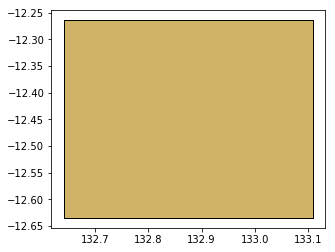

In [13]:
import geopandas as gpd
shape_plot = gpd.read_file(shape_file)
shape_plot.plot()
plt.show()

In [14]:
#copy attributes from shapefile and define shape_name
geom_crs = geometry.CRS(shapes.crs_wkt)
geo = shapes[i]['geometry']
geom = geometry.Geometry(geo, crs=geom_crs)
geom_bs = shapely.geometry.shape(shapes[i]['geometry'])
shape_name = shape_file.split('/')[-1].split('.')[0]+'_'+str(i)

In [15]:
# # #check if the file has already been written:
# filename = netcdf_output_loc+shape_name+'NoPizza.nc'
# if os.path.isfile(filename):
#     print('{} already exists'.format(filename))
#     sys.exit(0)

In [16]:
# #bring in dask and start it running
# import dask
# dask.set_options(get=dask.get)

In [17]:
#tell the datacube which app to use
dc = datacube.Datacube(app='dc-nbart')

In [18]:
##sensor changes here###FIXME

In [19]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Define temporal range
start_of_epoch = '2016-01-01'
#start_of_epoch = '2016-01-01'
#need a variable here that defines a rolling 'latest observation'
end_of_epoch =  '2016-12-31'

In [20]:
#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = ['blue',
                     'green',
                     'red',
                     'nir',
                     'swir1',
                     'swir2'
                     ]

In [21]:
query = {
    'time': (start_of_epoch, end_of_epoch), 'geopolygon': geom,
    'dask_chunks': {'time': 5},
}

For sensor in sensors:
Load data
calculate tcw count
calculate mean tcw count
calculate percentile tcw count (low and high)
calculate
plot mean tcw count



In [22]:
#this is done separately instead of in a loop because the datasets can be quite large.
#currently this is a way of memory handling -there is probably a better way of doing it.
sensor1_nbart=load_nbart('ls5',query,bands_of_interest)
sensor2_nbart=load_nbart('ls7',query,bands_of_interest)
sensor3_nbart=load_nbart('ls8',query,bands_of_interest)

loading ls5_nbart_albers
did not load ls5_nbart_albers
loading ls7_nbart_albers
loaded ls7_nbart_albers
making mask ls7_pq_albers
masked ls7_nbart_albers with ls7_pq_albers and filtered terrain
loading ls8_nbart_albers
loaded ls8_nbart_albers
making mask ls8_pq_albers
masked ls8_nbart_albers with ls8_pq_albers and filtered terrain


### Calculate wetness for each timeslice

In [23]:
#run the tcw transform on the surface reflectance data
wetness_sensor1_nbart=calc_wetness(sensor1_nbart,'ls5')
wetness_sensor2_nbart=calc_wetness(sensor2_nbart,'ls7')
wetness_sensor3_nbart=calc_wetness(sensor3_nbart,'ls8')

did not calculate wetness for ls5
calculated wetness for ls7
calculated wetness for ls8


### Calculate wetness over the threshold for each timeslice (remove values under the threshold)

In [24]:
#run function to add overthreshold wetness to the wetness arrays

calc_wetveg_overthresh(wetness_sensor1_nbart)
calc_wetveg_overthresh(wetness_sensor2_nbart)
calc_wetveg_overthresh(wetness_sensor3_nbart)

did not calculate wetness overthreshold
thresholded wetness added to array
thresholded wetness added to array


<xarray.Dataset>
Dimensions:            (time: 35, x: 2080, y: 1627)
Coordinates:
  * time               (time) datetime64[ns] 2016-01-08T01:10:29 ...
  * y                  (y) float64 -1.293e+06 -1.293e+06 -1.293e+06 ...
  * x                  (x) float64 7.089e+04 7.091e+04 7.094e+04 7.096e+04 ...
Data variables:
    wetness            (time, y, x) float64 nan nan nan nan nan nan nan nan ...
    water_plus_wetveg  (time, y, x) float64 nan nan nan nan nan nan nan nan ...
Attributes:
    crs:      EPSG:3577
    affine:   | 25.00, 0.00, 70875.00|\n| 0.00,-25.00,-1293125.00|\n| 0.00, 0...

## count number of wetness scenes and number of times tcw above threshold for each pixel

In [25]:
counts_sensor_1_nbart = count_wets(wetness_sensor1_nbart)
counts_sensor_2_nbart = count_wets(wetness_sensor2_nbart)
counts_sensor_3_nbart = count_wets(wetness_sensor3_nbart)

did not count
counted
counted


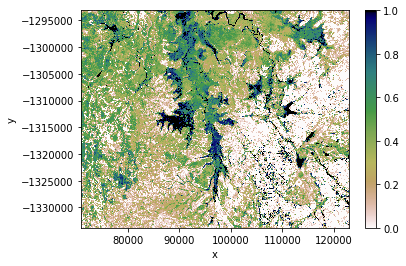

In [26]:
test = counts_sensor_3_nbart['threshold count']/counts_sensor_3_nbart['wet count']
test.plot(cmap ='gist_earth_r')
plt.show()

## divide the number of times wetness is seen per pixel by the number of wetness scenes per pixel to get a proportion of time that the pixel is wet

In [27]:
counts_list = [counts_sensor_1_nbart, counts_sensor_2_nbart,counts_sensor_3_nbart]
threshold_list =[]
wet_list=[]
for acount in counts_list:
    #test for data existence
    if acount is not None:
        wet_count = acount['wet count']
        threshold = acount['threshold count']
        threshold_list.append(threshold)
        wet_list.append(wet_count)
#times wetness is over threshold by pixel         L
threshold_allsensors = sum(threshold_list) 
#number of wetness scenes by pixel
wet_count_allsensors = sum(wet_list)        
wet_proportion_allsensors = threshold_allsensors/wet_count_allsensors

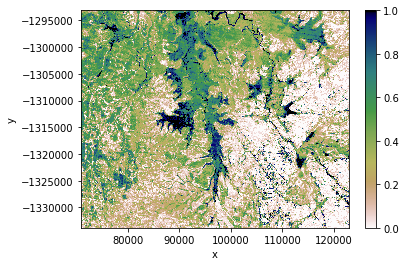

In [28]:
plt.clf()
wet_proportion_allsensors.plot(cmap ='gist_earth_r')
plt.show()

In [29]:
print('successfully ran TCW for '+shape_name+' polygon number '+str(i))
eprint('successfully ran TCW for '+shape_name+' polygon number '+str(i))

successfully ran TCW for Kevin_0 polygon number 0


successfully ran TCW for Kevin_0 polygon number 0


## this is to steal the crs from whichever wetness array actually has one

In [30]:
if wetness_sensor1_nbart is not None:
    crs = wetness_sensor1_nbart.crs
else:
    if wetness_sensor2_nbart is not None:
        crs = wetness_sensor2_nbart.crs
    else: 
        crs = wetness_sensor3_nbart.crs
print(crs)     

EPSG:3577


In [31]:
# write_your_netcdf(wet_proportion_allsensors,'tcw',filename=filename, crs=crs)
# print('successfully wrote tcw netcdf for '+shape_name+' polygon number '+str(i))
# eprint('successfully wrote tcw netcdf for for '+shape_name+' polygon number '+str(i))

In [32]:
# #overthresh is observations over our wetness threshold count per pixel
# write_your_netcdf(threshold_allsensors,'overthresh',filename=netcdf_output_loc+shape_name+'_overthresh.nc',crs=crs)
# print('successfully wrote overthresh netCDF for '+shape_name+' polygon number '+str(i))
# eprint('successfully wrote overthresh netCDFfor '+shape_name+' polygon number '+str(i))

In [33]:
# #clear_observations is count of wetness scenes at pixel
# write_your_netcdf(wet_count_allsensors,'clearobs',filename=netcdf_output_loc+shape_name+'_clearobs.nc',crs=crs)
# print('successfully wrote clearobs netCDF for '+shape_name+' polygon number '+str(i))
# eprint('successfully wrote clearobs netCDFfor '+shape_name+' polygon number '+str(i))

## Calculate wet and dry seasons in wetness based on Dec-April wet season

In [34]:
#calculate wet and dry season wetness using functions
wet_wetness_s1 = wet_vals(wetness_sensor1_nbart)
wet_wetness_s2 = wet_vals(wetness_sensor2_nbart)
wet_wetness_s3 = wet_vals(wetness_sensor3_nbart)

#note wet and dry seasons are defined in the functions blocks
dry_wetness_s1 = dry_vals(wetness_sensor1_nbart)
dry_wetness_s2 = dry_vals(wetness_sensor2_nbart)
dry_wetness_s3 = dry_vals(wetness_sensor3_nbart)

In [35]:
#check that the months are within range
dry_wetness_s2.time.dt.month

<xarray.DataArray 'month' (time: 13)>
array([5, 5, 5, 5, 6, 6, 6, 7, 7, 8, 8, 8, 9])
Coordinates:
  * time     (time) datetime64[ns] 2016-05-07T01:12:49 ...

In [36]:
#make an array of all the wetnessess
tcw_list = []
for wetness in [wetness_sensor1_nbart,wetness_sensor2_nbart, wetness_sensor3_nbart]:
    if wetness is not None:
        tcw_list.append(wetness)
tcw= xr.concat(tcw_list,dim='time')

In [37]:
#make an array of only the wet season tcw
wet_wetnessess = []
for sensor_wet_wetness in [wet_wetness_s1,wet_wetness_s2, wet_wetness_s3]:
    if sensor_wet_wetness is not None:
        wet_wetnessess.append(sensor_wet_wetness)
wet_season_tcw= xr.concat(wet_wetnessess,dim='time')

In [38]:
#make an array of only the dry season tcw
dry_wetnessess = []
for sensor_dry_wetness in [dry_wetness_s1,dry_wetness_s2, dry_wetness_s3]:
    if sensor_dry_wetness is not None:
        dry_wetnessess.append(sensor_dry_wetness)
dry_season_tcw= xr.concat(dry_wetnessess,dim='time')

MemoryError: 

## Calculate mean, median,percentile range in wetness
### Do this for wet season, dry season and total

In [190]:
#________________________this section in development

### time means

In [191]:
#calulate wet season, dry season and total time means
mean_wet_tcw = wet_season_tcw.mean(dim='time')
mean_dry_tcw = dry_season_tcw.mean(dim='time')
mean_tcw = tcw.mean(dim='time')

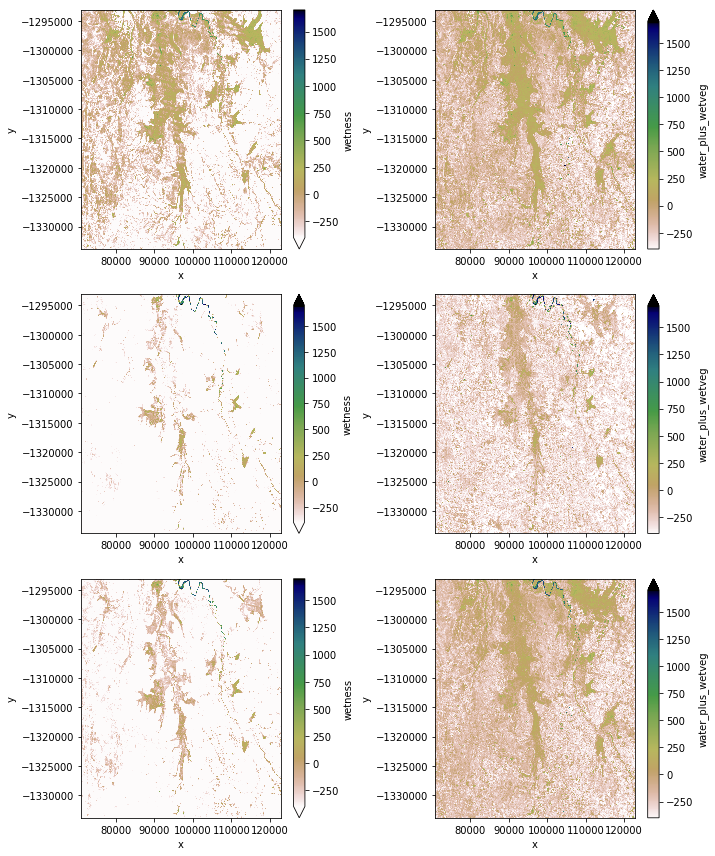

In [192]:
plt.clf()
fig,axes = plt.subplots(ncols=2,nrows=3,figsize =(10,12))
mean_wet_tcw.wetness.plot(ax=axes[0,0],cmap = 'gist_earth_r', vmin=-400, vmax=1700)
mean_dry_tcw.wetness.plot(ax=axes[1,0],cmap = 'gist_earth_r', vmin=-400, vmax=1700)
mean_tcw.wetness.plot(ax=axes[2,0],cmap = 'gist_earth_r', vmin=-400, vmax=1700)

mean_wet_tcw.water_plus_wetveg.plot(ax=axes[0,1],cmap = 'gist_earth_r',vmin=-400, vmax=1700)
mean_dry_tcw.water_plus_wetveg.plot(ax=axes[1,1],cmap = 'gist_earth_r',vmin=-400, vmax=1700)
mean_tcw.water_plus_wetveg.plot(ax=axes[2,1],cmap = 'gist_earth_r',vmin=-400, vmax=1700)
plt.tight_layout()
plt.show()

In [195]:
# do median
median_wet_wetness = wet_season_tcw.median(dim='time', keep_attrs=True)
median_dry_wetness = dry_season_tcw.median(dim='time', keep_attrs=True)
median_wetness = tcw.median(dim='time', keep_attrs=True)

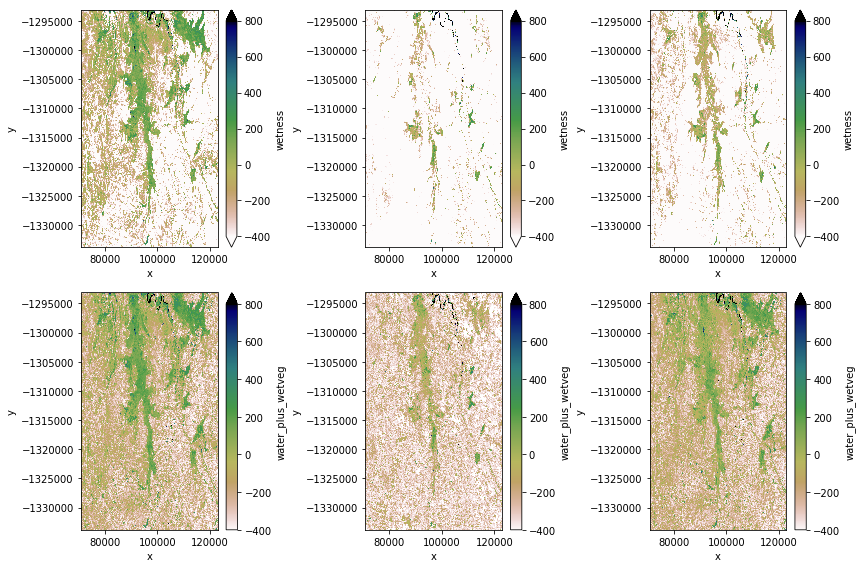

In [209]:
plt.clf()
fig,axes = plt.subplots(ncols=3,nrows=2,figsize =(12,8))
median_wet_wetness.wetness.plot(ax=axes[0,0],cmap = 'gist_earth_r', vmin=-400, vmax=800)
median_dry_wetness.wetness.plot(ax=axes[0,1],cmap = 'gist_earth_r', vmin=-400, vmax=800)
median_wetness.wetness.plot(ax=axes[0,2],cmap = 'gist_earth_r', vmin=-400, vmax=800)

median_wet_wetness.water_plus_wetveg.plot(ax=axes[1,0],cmap = 'gist_earth_r', vmin=-400, vmax=800)
median_dry_wetness.water_plus_wetveg.plot(ax=axes[1,1],cmap = 'gist_earth_r', vmin=-400, vmax=800)
median_wetness.water_plus_wetveg.plot(ax=axes[1,2],cmap = 'gist_earth_r', vmin=-400, vmax=800)
plt.tight_layout()
#fig.subplots_adjust(wspace=2)
plt.show()

In [210]:
# do standard deviation
wet_sd = wet_season_tcw.std(dim='time', keep_attrs='True',skipna=True)
dry_sd = dry_season_tcw.std(dim='time', keep_attrs='True',skipna=True)
tcw_sd = tcw.std(dim='time', keep_attrs='True',skipna=True)

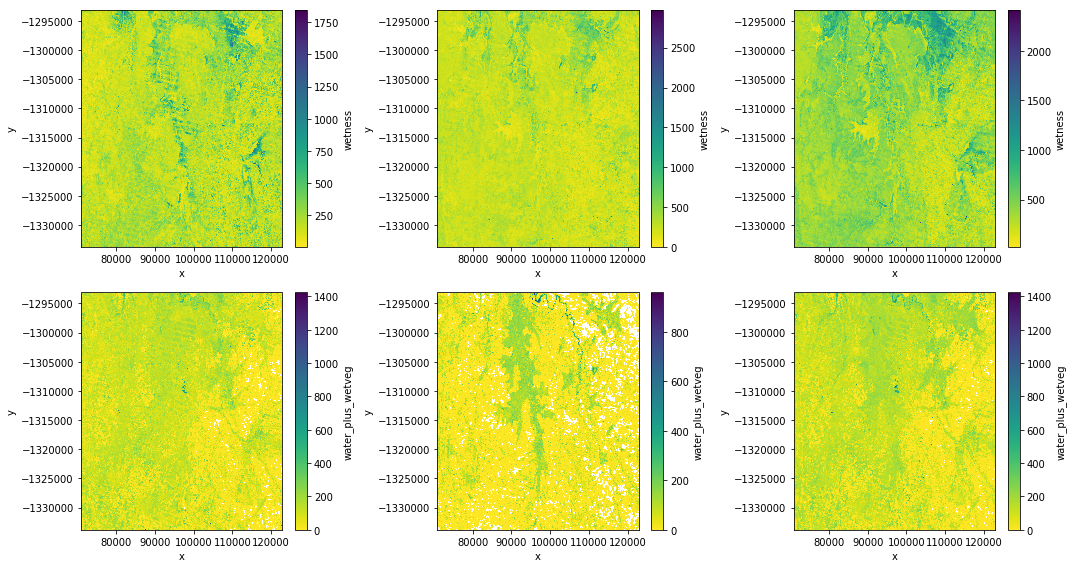

In [219]:
plt.clf()
fig,axes = plt.subplots(ncols=3,nrows=2,figsize =(15,8))
#do for total tcw
wet_sd.wetness.plot(ax=axes[0,0],cmap = 'viridis_r')#, vmin=-400, vmax=800)
dry_sd.wetness.plot(ax=axes[0,1],cmap = 'viridis_r')#, vmin=-400, vmax=800)
tcw_sd.wetness.plot(ax=axes[0,2],cmap = 'viridis_r')#, vmin=-400, vmax=800)

#do for thresholded tcw
wet_sd.water_plus_wetveg.plot(ax=axes[1,0],cmap = 'viridis_r')#, vmin=-400, vmax=800)
dry_sd.water_plus_wetveg.plot(ax=axes[1,1],cmap = 'viridis_r')#, vmin=-400, vmax=800)
tcw_sd.water_plus_wetveg.plot(ax=axes[1,2],cmap = 'viridis_r')#, vmin=-400, vmax=800)
plt.tight_layout()
#fig.subplots_adjust(wspace=2)
plt.show()

#brighter areas are higher sd

## Interquartile ranges still in development, pending what we want to do to them!

In [ ]:
# do quartile range
#Nan percentile needed to deal with nans
wet_90 = wet.reduce(np.nanpercentile, dim = 'time', q = 90, keep_attrs=True)
wet_10 = wetness_sensor1_nbart.reduce(np.nanpercentile, dim = 'time', q = 10, keep_attrs=True)

In [141]:
#Interpercentile range/ highest and lowest 10th percent
wet1_under90 = wetness_sensor1_nbart.where(wetness_sensor1_nbart.wetness>=threshold95).dropna(dim = 'time')
wet1_over90
wet1_over10
wet1_under10
dry_yrs = year_avg_sp.where(year_avg_sp.rainfall<=threshold5).dropna(dim = 'time')

NameError: name 'threshold95' is not defined